<a href="https://colab.research.google.com/github/Mohamedtahaahmedtaha/Sentiment-Analysis-for-Mental-Health/blob/main/Sentiment_Analysis_for_Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
suchintikasarkar_sentiment_analysis_for_mental_health_path = kagglehub.dataset_download('suchintikasarkar/sentiment-analysis-for-mental-health')

print('Data source import complete.')


100%|██████████| 11.1M/11.1M [00:00<00:00, 49.7MB/s]

Extracting files...


Data source import complete.


import libraries

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/data/Combined Data.csv')


In [5]:
data.head()

Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

In [6]:
data.shape

(53043, 3)

In [7]:
data.describe()

Unnamed: 0
count  53043.000000
mean   26521.000000
std    15312.339501
min        0.000000
25%    13260.500000
50%    26521.000000
75%    39781.500000
max    53042.000000

missing values was found

In [8]:
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None


In [9]:
print("Missing Values:")
print(data.isna().sum())

Missing Values:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [10]:
data.isna().sum()/len(data)

Unnamed: 0    0.000000
statement     0.006825
status        0.000000
dtype: float64

dealing with it

In [11]:
data['statement'] = data['statement'].fillna('')

7 status

In [12]:
data['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

 right-skewed distribution (also known as positively skewed)

count    53043.000000
mean       574.764342
std        844.721094
min          0.000000
25%         77.000000
50%        313.000000
75%        748.000000
max      32759.000000
Name: statement_length, dtype: float64


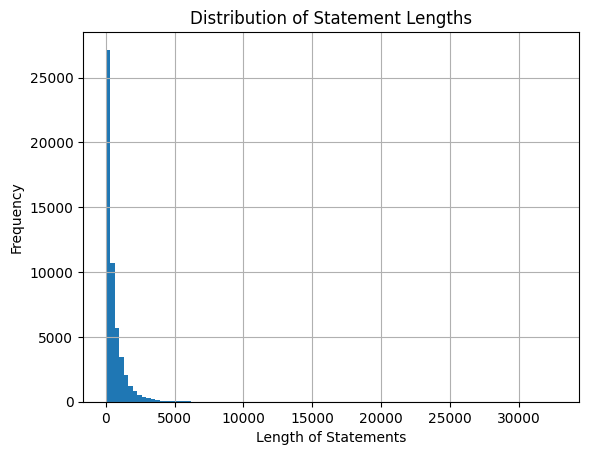

In [13]:
# Calculate the length of each statement
data['statement_length'] = data['statement'].apply(len)

# Display basic statistics of statement lengths
print(data['statement_length'].describe())

# Plot the distribution of statement lengths
data['statement_length'].hist(bins=100)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

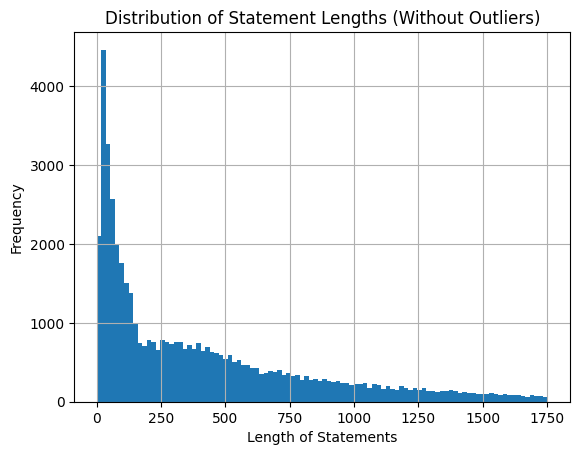

In [14]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['statement_length'].quantile(0.25)
Q3 = data['statement_length'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = data[(data['statement_length'] >= lower_bound) & (data['statement_length'] <= upper_bound)]
# Plot the distribution of statement lengths without outliers
filtered_df['statement_length'].hist(bins=100)
plt.title('Distribution of Statement Lengths (Without Outliers)')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

Most of the data is normal and they are 16K in number.
People with depression are 15K.
Suicidal individuals are 10.6k

In [15]:
fig = px.histogram(data, x='status', title='Distribution of Mental Health Status', color="status")
fig.show()

In [16]:
data['text_length'] = data['statement'].apply(lambda x: len(str(x).split()))
fig = px.histogram(data, x='text_length', title='Text Length Distribution')
fig.show()

In [17]:
nlp = spacy.load("en_core_web_sm")

In [18]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

In [19]:
# Data Preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbersظ
    text = text.translate(str.maketrans('', '', string.punctuation))
    doc = nlp(text)

    # Lemmatize and remove stop words
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    # Join the tokens back into a single string
    return ' '.join(tokens)


data['cleaned_statement'] = data['statement'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [20]:
data.head()

Unnamed: 0                                          statement   status  \
0           0                                         oh my gosh  Anxiety   
1           1  trouble sleeping, confused mind, restless hear...  Anxiety   
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3           3  I've shifted my focus to something else but I'...  Anxiety   
4           4  I'm restless and restless, it's been a month n...  Anxiety   

   statement_length  text_length  \
0                10            3   
1                64           10   
2                78           14   
3                61           11   
4                72           14   

                                   cleaned_statement  
0                                            oh gosh  
1    trouble sleep confused mind restless heart tune  
2  wrong dear forward doubt stay restless restles...  
3                           ve shift focus m worried  
4                 m restless restless month boy mean

In [21]:
# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['cleaned_statement'] = data['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [22]:
# Data Augmentation
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

data['augmented_statement'] = data['statement'].apply(augment_text)
augmented_df = data[['statement', 'status']].copy()
augmented_df['statement'] = data['augmented_statement']
data = pd.concat([data, augmented_df])

In [23]:
# Reapply preprocessing on augmented data
data['cleaned_statement'] = data['statement'].apply(lambda x: preprocess_text(x))
data['cleaned_statement'] = data['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [24]:
data['cleaned_statement'] = data['cleaned_statement'].fillna('')

In [25]:
print(data[['statement', 'cleaned_statement']].head())


                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                   cleaned_statement  
0                                            oh gosh  
1    trouble sleep confused mind restless heart tune  
2  wrong dear forward doubt stay restless restles...  
3                                shift focus worried  
4                   restless restless month boy mean  


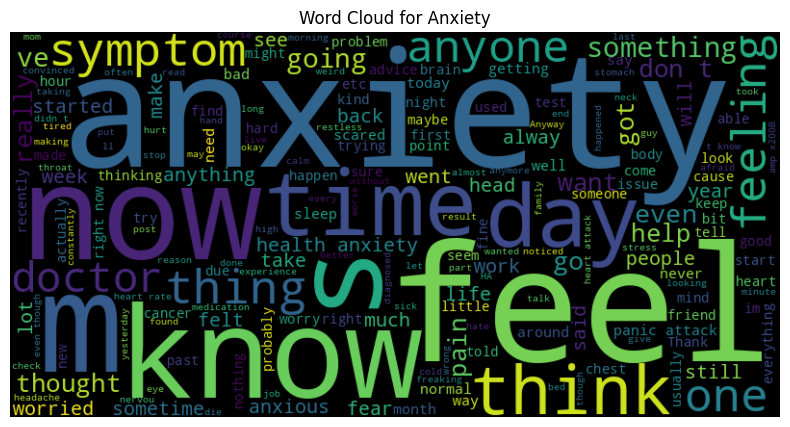

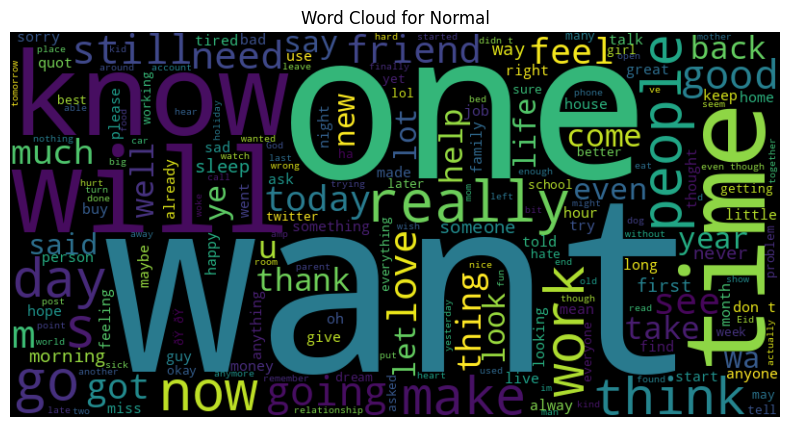

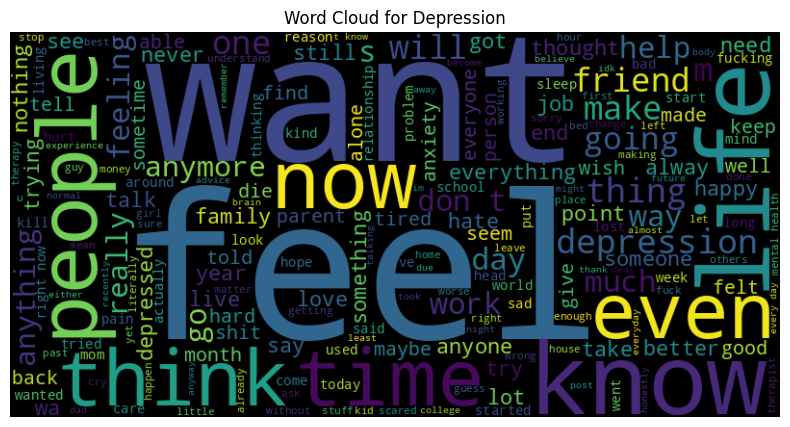

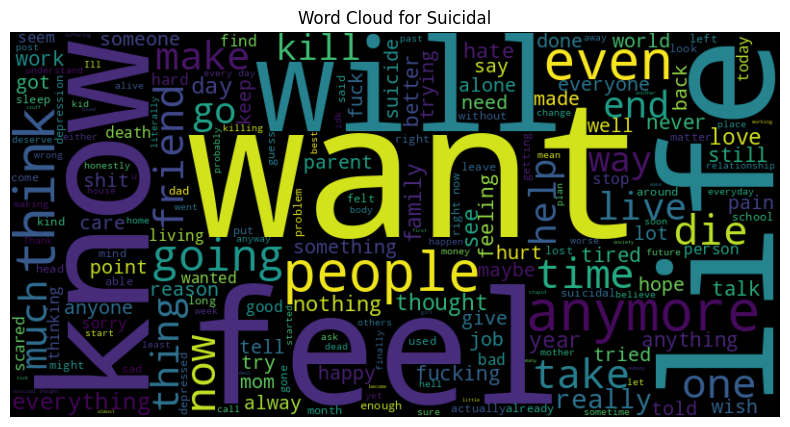

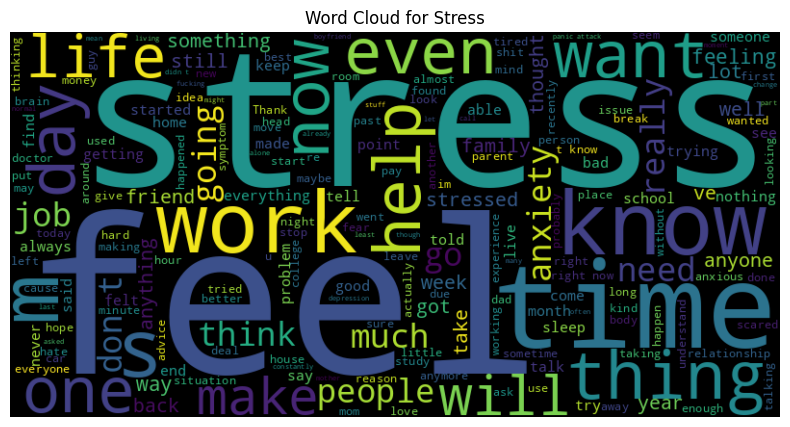

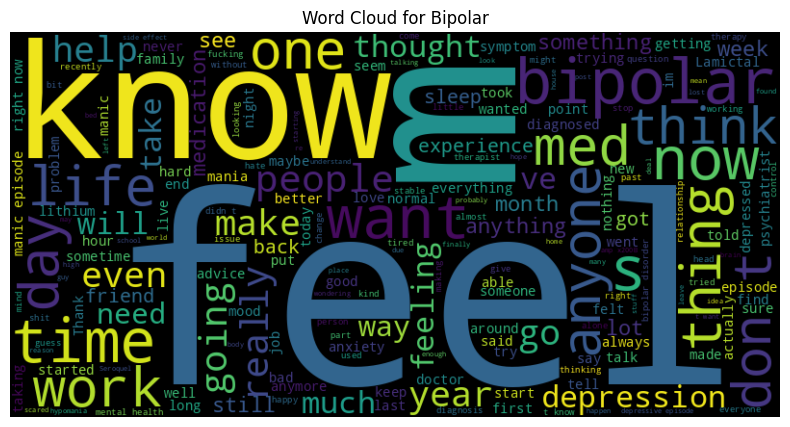

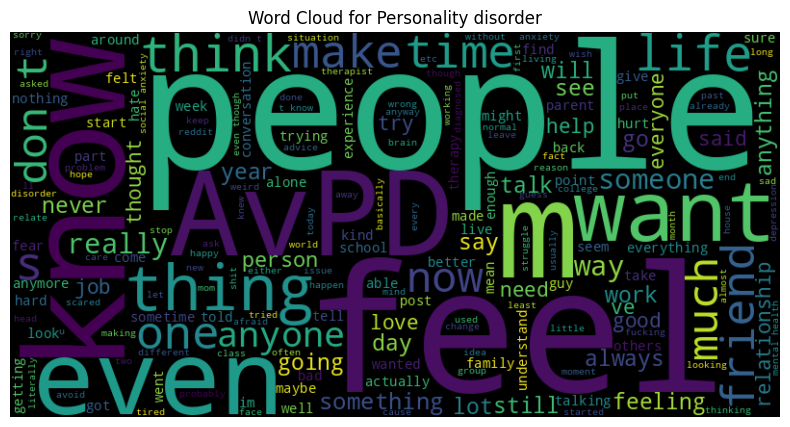

In [26]:
# Create a function to generate and display a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each status
statuses = data['status'].unique()

for status in statuses:
    status_text = ' '.join(data[data['status'] == status]['statement'])
    generate_word_cloud(status_text, title=f'Word Cloud for {status}')

In [27]:
# Word Cloud
"""all_text = ' '.join(data['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements')
plt.show()"""

"all_text = ' '.join(data['cleaned_statement'])\nwordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)\nplt.figure(figsize=(10, 5))\nplt.imshow(wordcloud, interpolation='bilinear')\nplt.axis('off')\nplt.title('Word Cloud of Cleaned Statements')\nplt.show()"

In [28]:
# Status Distribution
fig = px.pie(data, names='status', title='Proportion of Each Status Category')
fig.show()

In [29]:
# Splitting the data
X = data['cleaned_statement']
y = data['status']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
print(f'X_train size: {len(X_train)}')
print(f'X_test size: {len(X_test)}')
print(f'y_train size: {len(y_train)}')
print(f'y_test size: {len(y_test)}')

X_train size: 84868
X_test size: 21218
y_train size: 84868
y_test size: 21218


In [32]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [38]:
from sklearn.preprocessing import LabelEncoder


# Before fitting the models:
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the target variable (y_train)
label_encoder.fit(y_train)

# Transform both y_train and y_test to numerical labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [39]:
models = {'Logistic Regression': LogisticRegression(),
         'KNN': KNeighborsClassifier(),
         'Decision Tree': DecisionTreeClassifier(),
         'Random Forest': RandomForestClassifier(),
         'Gradient Boosting Classifier':GradientBoostingClassifier(),
         'Support Vector Machine': SVC(),
         'Stochastic Gradien Descent': SGDClassifier(),
         'xgb Classifier': XGBClassifier()}

In [41]:
def fit_score(models, X_train_tfidf, X_test_tfidf, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train_tfidf, y_train_encoded)
        model_scores[name] = cross_val_score(model,
                                             X_test_tfidf,
                                              y_test_encoded,
                                            scoring='accuracy',
                                            cv=3
                                            ).mean()

    return model_scores

In [42]:
model_scores = fit_score(models,X_train_tfidf,X_test_tfidf,y_train_encoded,y_test_encoded)

model_scores

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



{'Logistic Regression': np.float64(0.7196716066387184),
 'KNN': np.float64(0.3228863722728648),
 'Decision Tree': np.float64(0.6619850432859306),
 'Random Forest': np.float64(0.7015269707269525),
 'Gradient Boosting Classifier': np.float64(0.707747837196195),
 'Support Vector Machine': np.float64(0.7403617446500075),
 'Stochastic Gradien Descent': np.float64(0.7336691959353426),
 'xgb Classifier': np.float64(0.7450747753070277)}

<Axes: >

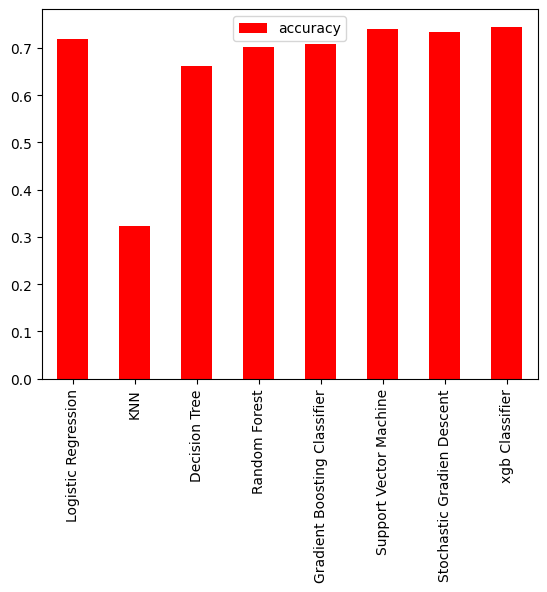

In [43]:
models = pd.DataFrame(model_scores, index=["accuracy"])
models.T.plot.bar(color="red")

In [ ]:

# Model Training with Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best Model
best_model = grid_search.best_estimator_

In [ ]:
# Model Training with Hyperparameter Tuning
param_grid = {
   # 'C': [0.01, 0.1, 1, 10, 100],
    'max_depth': [10,20,30,50],
    'n_estimators': [10,50,100]

}

model = XGBClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train_encoded)

# Best Model
best_model = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[19:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_iter" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:01:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_iter" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:04:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_iter" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:07:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_iter" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:10:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_iter" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:13:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_iter

In [ ]:
# Predictions
y_pred = best_model.predict(X_test_tfidf)

In [ ]:
# Evaluation
print("Best Parameters:")
print(grid_search.best_params_)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)
cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()

In [ ]:
# Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefs = best_model.coef_
for i, category in enumerate(best_model.classes_):
    top_features = coefs[i].argsort()[-10:]
    top_words = [feature_names[j] for j in top_features]
    top_scores = [coefs[i][j] for j in top_features]
    fig = go.Figure([go.Bar(x=top_words, y=top_scores)])
    fig.update_layout(title=f'Top Features for {category}')
    fig.show()